## Homework: FX Carry Strategy
### 3rd February, 2023

I deleted most code of the carry strategy and only kept the results, because according to the feedback, I probably misunderstood the requirements of the assignment. 

In [1]:
import sys
sys.version

'3.10.8 (main, Nov 24 2022, 08:09:04) [Clang 14.0.6 ]'

In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import plotnine as p9
import statsmodels.api as sm
import math

pd.options.mode.chained_assignment = None 

## Introduction

In this study, I'm implementing a FX carry stategy by borrowing in a low interest rate currency and lending another currency with high interest rate, which is achieved through a cross-currency swap.

After imported data from Quandl and achieved the strategy, I further compared strategies with different ways of selecting the foreign currency to lend, and discussed some possible ways to improve the strategy.

## Data

I imported data from Quandl, including one month UK overnight index swaps (OIS), spot rates for the dollar versus foreign currencies, and yield curve data. 

The currency to be borrowed in this strategy is **British Pound**. The foreign currencies to lend include **Vietnamese Dong, Thai Baht, and Philippine Peso**. I discarded Pakistani Rupee which was to be included, because the dataset is severely missing.

The time frame I chose if **from January 1, 2015 to December 1, 2022**.

#### Functions

In [80]:
myAPIkey = "yourAPI"
quandl.ApiConfig.api_key = myAPIkey


def get_UKOIS():

    UK_ISSC = quandl.get('YC/GBR_ISSC',returns="pandas")
    UK_ISSC = UK_ISSC[['0.08Y']]   
    
    UK_ISSS = quandl.get('YC/GBR_ISSS', returns="pandas")
    UK_ISSS = UK_ISSS[['0.08Y']]

    UK_OIS = pd.concat([UK_ISSC,UK_ISSS]).drop_duplicates()
    UK_OIS = UK_OIS.rename(columns={'0.08Y': 'uk-ois-1M'}) 

    UK_OIS = UK_OIS['2015-01-01':'2022-12-01']
    
    return UK_OIS


def get_fx_rate():

    gbr_rate = quandl.get('CUR/GBP')  # UK
    vnd_rate = quandl.get('CUR/VND')  # Vietnamese Dong
    thb_rate = quandl.get('CUR/THB')  # Thai Baht
    # pkr_rate = quandl.get('CUR/PKR')  # Pakistani Rupee
    php_rate = quandl.get('CUR/PHP')  # Philippine Peso

    gbr_rate = gbr_rate.rename(columns={'RATE': 'gbr-rate'}) 
    vnd_rate = vnd_rate.rename(columns={'RATE': 'vnd-rate'}) 
    thb_rate = thb_rate.rename(columns={'RATE': 'thb-rate'}) 
    # pkr_rate = pkr_rate.rename(columns={'RATE': 'pkr-rate'}) 
    php_rate = php_rate.rename(columns={'RATE': 'php-rate'}) 

    df_fx = gbr_rate.join(vnd_rate, how = "outer")
    df_fx = df_fx.join(thb_rate, how = "outer")
    df_fx = df_fx.join(php_rate, how = "outer")

    df_fx = df_fx.mask(df_fx == 0.0).ffill(downcast='infer')
    df_fx = df_fx.fillna(method='ffill')

    df_fx = df_fx['2015-01-01':'2022-12-01']

    return df_fx 


def get_yield_curves():

    vnd_yield = quandl.get('YC/VNM',returns="pandas")  # Vietnamese Dong
    thb_yield = quandl.get('YC/THA',returns="pandas")  # Thai Baht
    pkr_yield = quandl.get('YC/PAK',returns="pandas")  # Pakistani Rupee
    php_yield = quandl.get('YC/PHL',returns="pandas")  # Philippine Peso

    vnd_yield = vnd_yield[['1-Year','2-Year','3-Year','5-Year','7-Year','10-Year']]
    vnd_yield = vnd_yield.rename(columns={'1-Year': 'vnd-1Y', '2-Year': 'vnd-2Y','3-Year':'vnd-3Y','5-Year':'vnd-5Y',
    '7-Year':'vnd-7Y','10-Year':'vnd-10Y'}) 
    vnd_yield = vnd_yield['2015-01-01':'2022-12-01']

    thb_yield = thb_yield[['1-Year','2-Year','3-Year','5-Year','7-Year','10-Year']]
    thb_yield = thb_yield.rename(columns={'1-Year': 'thb-1Y', '2-Year': 'thb-2Y','3-Year':'thb-3Y','5-Year':'thb-5Y',
    '7-Year':'thb-7Y','10-Year':'thb-10Y'}) 
    thb_yield = thb_yield['2015-01-01':'2022-12-01']

    # pkr_yield = pkr_yield[['12-Month','3-Year','5-Year']]
    # pkr_yield = pkr_yield.rename(columns={'12-Month': 'pkr-1Y','3-Year':'pkr-3Y','5-Year':'pkr-5Y'}) 
    # pkr_yield = pkr_yield['2015-01-01':]

    php_yield = php_yield[['1-Year','2-Year','3-Year','5-Year','7-Year','10-Year']]
    php_yield = php_yield.rename(columns={'1-Year': 'php-1Y', '2-Year': 'php-2Y','3-Year':'php-3Y','5-Year':'php-5Y',
    '7-Year':'php-7Y','10-Year':'php-10Y'}) 
    php_yield = php_yield['2015-01-01':'2022-12-01']

    df_yield_curve = vnd_yield.join(thb_yield, how = "outer")
    df_yield_curve = df_yield_curve.join(php_yield, how = "outer")

    df_yield_curve = df_yield_curve.mask(df_yield_curve == 0.0).ffill(downcast='infer')
    df_yield_curve = df_yield_curve.fillna(method='ffill')
    
    return df_yield_curve


def get_treasury():

    df_treasury = quandl.get('USTREASURY/YIELD')
    df_treasury = df_treasury[['5 YR']]
    df_treasury = df_treasury.rename(columns={"5 YR":"treasury"})

    df_treasury = df_treasury.mask(df_treasury == 0.0).ffill(downcast='infer')
    df_treasury = df_treasury.fillna(method='ffill')

    df_treasury = df_treasury['2015-01-01':'2022-12-01']

    return df_treasury


def resample_weekly(year,df_yield_curve,df_fx,df_ukois,df_treasury):

    df = pd.concat([df_yield_curve[['vnd-'+year,'thb-'+year,'php-'+year]], df_fx, df_ukois, df_treasury],axis=1)
    df = df.resample('7D').asfreq()
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')  # fill the first row

    return df

#### Implement

* **UK overnight index swaps (OIS)**

An overnight index swap (OIS) is a type of financial derivative that allows an investor to exchange a floating rate of interest for a fixed rate of interest, based on the overnight interest rate for a particular currency. The overnight interest rate is a benchmark for the cost of borrowing or lending funds overnight in the interbank market for that currency.

Overnight index swaps (OIS) can be used in carry trade by providing a more accurate measure of the cost of borrowing in the low interest rate currency. This is because OIS rates reflect the actual cost of overnight borrowing in the interbank market, rather than relying on benchmark interest rates set by central banks.

In [5]:
df_ukois = get_UKOIS()  
df_ukois

,uk-ois-1M
Date,
2015-01-02,0.432741
2015-01-05,0.430936
2015-01-06,0.430856
2015-01-07,0.432791
2015-01-08,0.432369
...,...
2022-11-25,3.098105
2022-11-28,3.151724
2022-11-29,3.183710


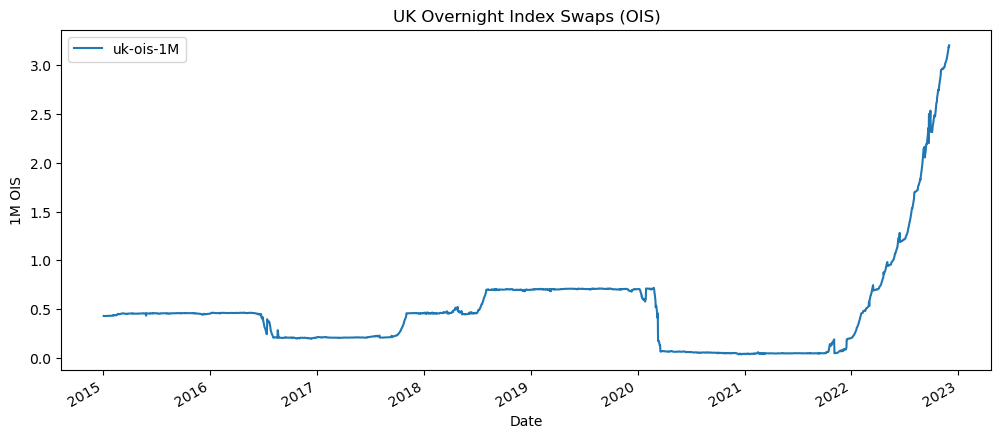

In [6]:
df_ukois.plot(title= "UK Overnight Index Swaps (OIS)", ylabel = "1M OIS" ,figsize = (12,5));

* **FX rates**

After obtaining the FX rates / spot rates for the dollar versus other currencies, we could observe that for all currencies, there is a roughly post-2020 decrease and subsequent increase in exchange rates.

In [7]:
df_fx = get_fx_rate()
df_fx

,gbr-rate,vnd-rate,thb-rate,php-rate
DATE,,,,
2015-01-01,0.644102,21401.000000,32.956360,44.752350
2015-01-02,0.644300,21401.000000,32.948660,44.752350
2015-01-03,0.652353,21416.433333,32.980760,44.819920
2015-01-04,0.655164,21416.433333,33.016810,44.859800
2015-01-05,0.655667,21383.333333,32.965980,45.037820
...,...,...,...,...
2022-11-27,0.827062,24798.515521,35.690624,56.700000
2022-11-28,0.829895,24798.515521,35.850000,56.788007
2022-11-29,0.832517,24760.000000,35.596721,56.561003


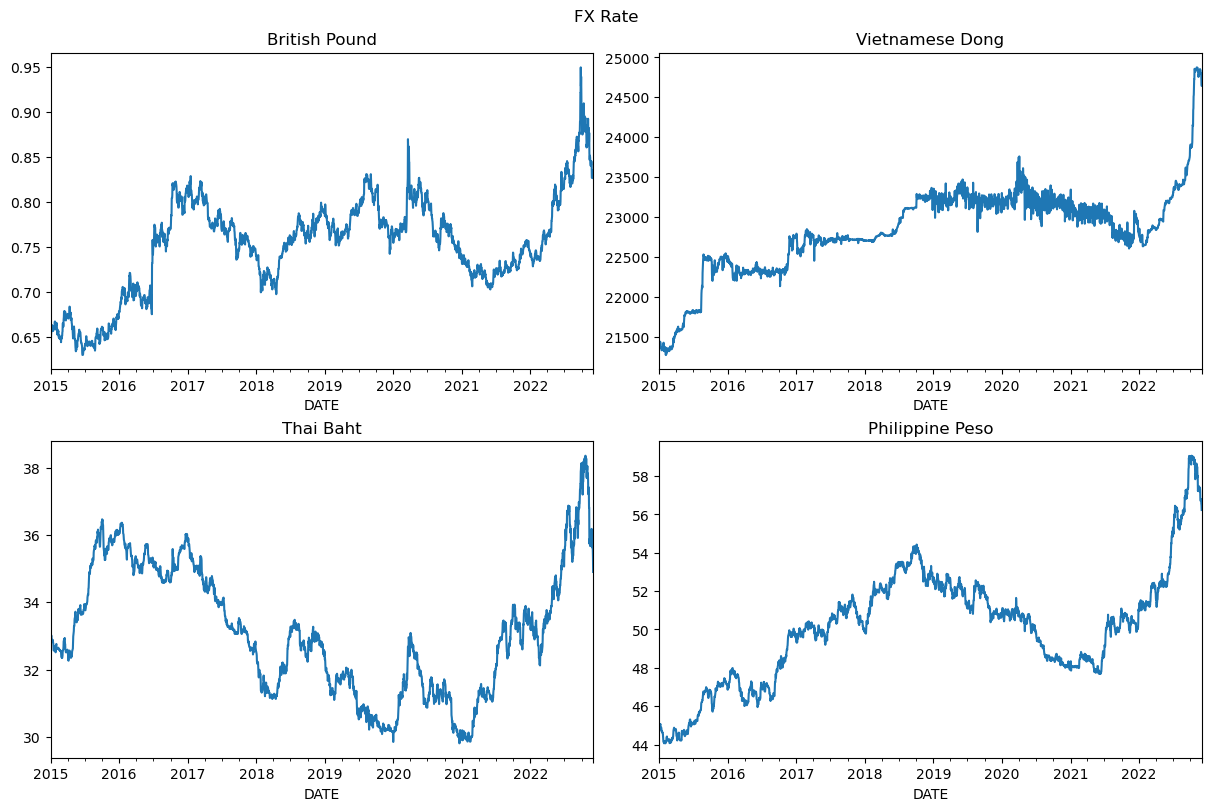

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2,constrained_layout=True)

df_fx['gbr-rate'].plot(ax=axes[0,0],title= "British Pound",figsize = (12,8))
df_fx['vnd-rate'].plot(ax=axes[0,1],title= "Vietnamese Dong",figsize = (12,8))
df_fx['thb-rate'].plot(ax=axes[1,0],title= "Thai Baht",figsize = (12,8))
df_fx['php-rate'].plot(ax=axes[1,1],title= "Philippine Peso",figsize = (12,8))

fig.suptitle("FX Rate");

* **Yield curves**

A yield curve is a graphical representation of the relationship between bond yields and their maturities. In finance, the yield curve is often used as an indicator of the direction of interest rates and the health of an economy. The shape of yield curve can be an important factor in determining the profitability of a carry trade strategy. A steep yield curve can indicate favorable conditions for carry trade, while a flat or inverted yield curve may indicate a less favorable environment.

After comparing the 1-Year, 2-Year, 3-Year, 5-Year, 7-Year and 10-Year yield curves of the three lending currencies, we could tell that Vietnamese Dong and Philippine Peso have more steep yield curves than Thai Baht. Before 2018, Vietnamese Dong roughly has the highest yield curve. After 2018, Philippine Peso yield curve became the highest.

In [83]:
df_yield_curve = get_yield_curves()
df_yield_curve.head()

,vnd-1Y,vnd-2Y,vnd-3Y,vnd-5Y,vnd-7Y,vnd-10Y,thb-1Y,thb-2Y,thb-3Y,thb-5Y,thb-7Y,thb-10Y,php-1Y,php-2Y,php-3Y,php-5Y,php-7Y,php-10Y
Date,,,,,,,,,,,,,,,,,,
2015-01-01,4.760,5.040,5.220,6.230,6.800,7.230,2.04,2.103,2.343,2.441,2.521,2.729,2.425,2.75,3.075,3.327,3.900,3.863
2015-01-02,4.760,5.040,5.220,6.230,6.800,7.230,2.04,2.103,2.343,2.441,2.521,2.729,2.425,2.75,3.075,3.327,3.900,3.863
2015-01-05,4.750,5.000,5.198,6.225,6.825,7.275,2.03,2.070,2.343,2.441,2.358,2.559,2.450,2.35,3.250,3.278,3.613,3.779
2015-01-06,4.760,5.056,5.244,6.234,6.800,7.280,2.00,2.049,2.343,2.211,2.324,2.522,2.450,2.45,2.975,3.244,3.875,3.700
2015-01-07,4.756,5.060,5.230,6.246,6.800,7.280,1.99,2.056,2.343,2.193,2.330,2.474,2.082,2.45,3.150,3.182,3.850,3.616


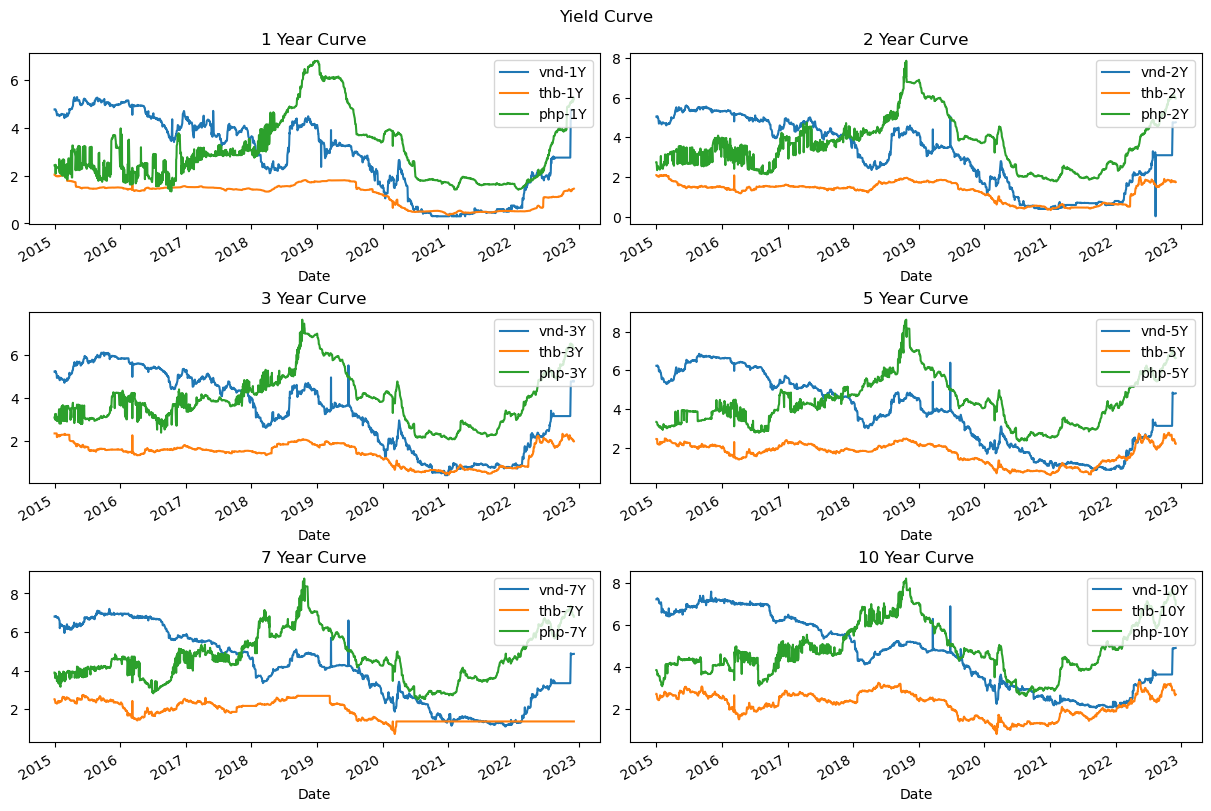

In [82]:
fig, axes = plt.subplots(nrows=3, ncols=2,constrained_layout=True)

df_yield_curve[['vnd-1Y','thb-1Y','php-1Y']].plot(ax=axes[0,0],title= "1 Year Curve",figsize = (12,8))
df_yield_curve[['vnd-2Y','thb-2Y','php-2Y']].plot(ax=axes[0,1],title= "2 Year Curve",figsize = (12,8))
df_yield_curve[['vnd-3Y','thb-3Y','php-3Y']].plot(ax=axes[1,0],title= "3 Year Curve",figsize = (12,8))
df_yield_curve[['vnd-5Y','thb-5Y','php-5Y']].plot(ax=axes[1,1],title= "5 Year Curve",figsize = (12,8))
df_yield_curve[['vnd-7Y','thb-7Y','php-7Y']].plot(ax=axes[2,0],title= "7 Year Curve",figsize = (12,8))
df_yield_curve[['vnd-10Y','thb-10Y','php-10Y']].plot(ax=axes[2,1],title= "10 Year Curve",figsize = (12,8))

fig.suptitle("Yield Curve");

* **5 year treasury rate**

The treasury rate is the yield on a US treasury security, such as a treasury bill or treasury note. This rate is used as a benchmark for the pricing of other financial products, including corporate bonds, mortgages, and other fixed-income securities. In a carry trade strategy, the Treasury rate can be used as a reference point to determine the profitability of borrowing in one currency and investing in another. 

The spread between the treasury rate and the interest rate of the borrowing currency could be a benchmark to evaluate the profitability of borrowing in one currency and investing in another. A positive spread may indicate favorable conditions for a carry trade strategy, while a negative spread may indicate a less favorable environment.

In [11]:
df_treasury = get_treasury()
df_treasury

,treasury
Date,
2015-01-02,1.61
2015-01-05,1.57
2015-01-06,1.50
2015-01-07,1.47
2015-01-08,1.50
...,...
2022-11-25,3.85
2022-11-28,3.88
2022-11-29,3.92


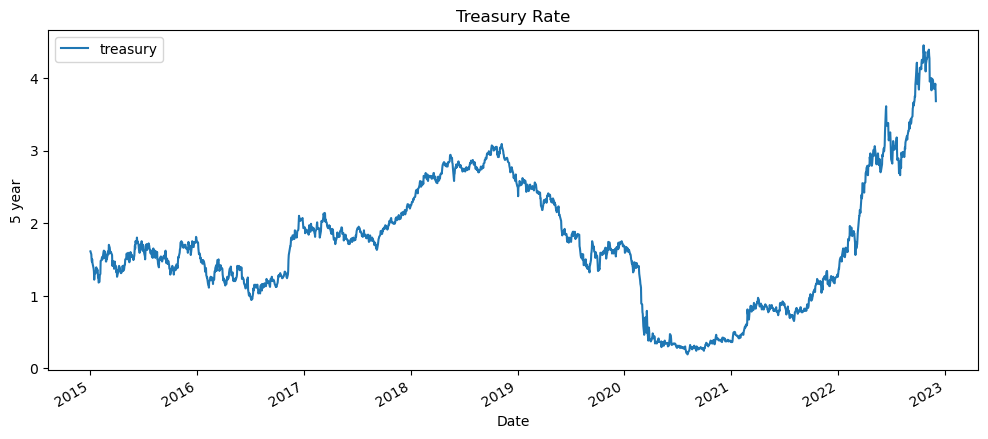

In [12]:
df_treasury.plot(title= "Treasury Rate", ylabel = "5 year" ,figsize = (12,5));

I seperated and combined the datasets by different yield curves for them to be used in the following FX trade strategy.

In [84]:
df_1Y = resample_weekly('1Y',df_yield_curve,df_fx,df_ukois,df_treasury)
df_2Y = resample_weekly('2Y',df_yield_curve,df_fx,df_ukois,df_treasury)
df_3Y = resample_weekly('3Y',df_yield_curve,df_fx,df_ukois,df_treasury)
df_5Y = resample_weekly('5Y',df_yield_curve,df_fx,df_ukois,df_treasury)
df_7Y = resample_weekly('7Y',df_yield_curve,df_fx,df_ukois,df_treasury)
df_10Y = resample_weekly('10Y',df_yield_curve,df_fx,df_ukois,df_treasury)

In [14]:
df_1Y

,vnd-1Y,thb-1Y,php-1Y,gbr-rate,vnd-rate,thb-rate,php-rate,uk-ois-1M,treasury
2015-01-01,4.760,2.040,2.4250,0.644102,21401.000000,32.95636,44.752350,0.432369,1.50
2015-01-08,4.730,1.980,2.4250,0.662979,21406.166667,32.87441,44.939840,0.432369,1.50
2015-01-15,4.512,1.970,2.3500,0.658714,21335.800000,32.76222,44.711500,0.431764,1.22
2015-01-22,4.535,1.970,2.3250,0.666380,21369.166667,32.61746,44.258410,0.434061,1.39
2015-01-29,4.488,1.990,2.1270,0.663595,21329.166667,32.72031,44.102840,0.435146,1.28
...,...,...,...,...,...,...,...,...,...
2022-11-03,2.750,1.420,4.8679,0.876480,24863.253650,37.82700,58.649998,2.945258,4.36
2022-11-10,2.750,1.379,5.0409,0.876571,24866.343789,36.81850,57.998501,2.956386,3.95
2022-11-17,4.727,1.365,5.0689,0.840505,24801.588827,35.85600,57.430501,3.007526,3.93
2022-11-24,4.732,1.437,5.0667,0.826895,24844.726631,35.92000,56.762000,3.079973,3.93


## Fixed-Float Carry Strategy

A carry trade is a trading strategy where an investor borrows money in a currency with a low interest rate and invests it in a currency with a higher interest rate. The aim is to profit from the difference between the interest rates.

If an investor borrows British Pound, which has a low interest rate, and invests the proceeds in Vietnamese Dong, which has a higher interest rate, the investor can potentially earn a profit from the difference between the two interest rates. This type of trade can be used to take advantage of differences in interest rates between countries, and is often used by currency traders and hedge funds.

I implemented the strategy as follows.

* **Step1**: In the first week of the carry strategy, we choose the foreign currency with the largest yield curve rate and set a notional of 10MM USD. We compute the cash flows to be borrowed and lent, and convert them to USD. In the borrowing currency, assume a rate of OIS+50bp, paid on 0.8 the notional amount in the borrowing currency for each active position. In the lending currency, assume the schedule has a coupon every quarter at the 5Y treasury rate.

* **Step2**: In the following weeks, we sell last week's position and calculate PnL. After that, we normalize notional of 10MM USD again and repeat Step1. 

#### Functions

In [86]:
def borrowing_amount(df, today, notional):
   
    return borrowing_rate, borrowing_currency


def buy_funding_currency(df,today,borrowing_currency, borrowing_rate):
        
    return usd


def foreign_currency_share(df,today,notional,select_bond):
    
    return usd


def carry_strategy(df):

    return df_result

In [73]:
def performance_metrics(df, year, ret_plot_show = False, cumulative_pnl_plot_show = False):
    
    # returns = df['cumulative_return'].to_frame()
    pnl = df['pnl'].to_frame()
    ret = pnl / 10000000 
    cumulative_pnl = df['cumulative_pnl'].to_frame()
    
    metrics = pd.DataFrame(index=pnl.columns)
    
    metrics['Mean'] = round(ret.mean(),6)
    metrics['Vol'] = round(ret.std(),6)
    metrics['Sharpe'] = round(ret.mean()/ret.std(),4)

    metrics['Min'] = min(ret['pnl'].dropna())
    metrics['Max'] = max(ret['pnl'].dropna())
        
    metrics['Max Drawdown'] = (cumulative_pnl['cumulative_pnl'] - 
                               cumulative_pnl['cumulative_pnl'].rolling(len(cumulative_pnl['cumulative_pnl']), 
                                                                 min_periods=1).max()).min()

    metrics['Max Drawdown'] = metrics['Max Drawdown'] / 10000000
        
    if ret_plot_show == True:
        ret = ret.rename(columns={"pnl": "ret"})
        ret.plot(title="Return - " +year, ylabel = "Return (%)" ,figsize = (11.8,5))
        
    if cumulative_pnl_plot_show == True:
        cumulative_pnl.plot(title="Cumulative PnL - " +year, ylabel = "Cumulative PnL" ,figsize = (12,5))

    metrics = metrics.rename(index={'pnl': year})
        
    return metrics

#### Implement

Using the dataset of one-year yield curves, the result is as follows. The Sharpe ratio if 0.2658, and the maximum drawdown is -0.197424. Even though the performance is not outstanding, we could observe a stable increase in cumulative PnL.

In [87]:
result_1Y = carry_strategy(df_1Y)
result_1Y 

,borrow,lend,pnl,cumulative_pnl
2015-01-08,9787735.744863,10019033.490505,-231297.745642,-231297.745642
2015-01-15,10139819.834839,9660159.450973,479660.383866,248362.638223
2015-01-22,9958644.116167,10280245.034258,-321600.91809,-73238.279867
2015-01-29,10117006.859372,9859386.303495,257620.555877,184382.27601
2015-02-05,10246027.867317,10051560.778448,194467.088868,378849.364878
...,...,...,...,...
2022-11-03,10071532.655215,10257720.410271,-186187.755056,22458075.433107
2022-11-10,10274553.865264,9590330.370277,684223.494987,23142298.928094
2022-11-17,10717475.149128,10074100.603089,643374.546039,23785673.474133
2022-11-24,10449812.189355,10128207.457987,321604.731368,24107278.205501


,Mean,Vol,Sharpe,Min,Max,Max Drawdown
1 Year (Strategy1),0.005969,0.022458,0.2658,-0.09522,0.122592,-0.197424


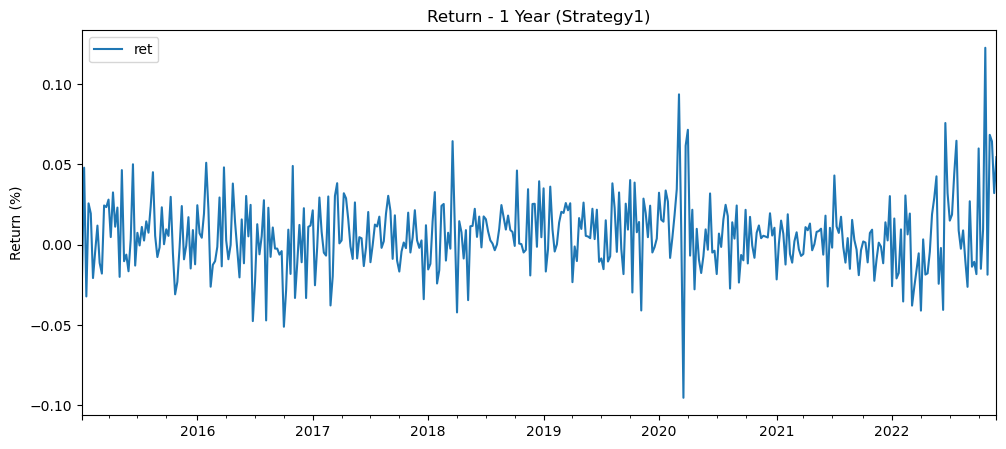

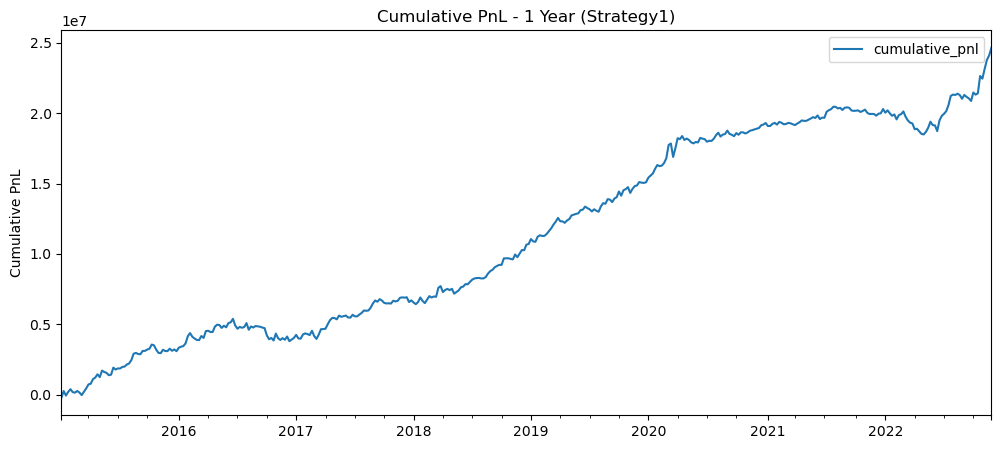

In [105]:
metrics_1Y = performance_metrics(result_1Y, "1 Year (Strategy1)", ret_plot_show = True, cumulative_pnl_plot_show = True)
metrics_1Y

## Analysis

To analyze and try to improve the carry trade strategy, I did the following discussions:

* Compare the result of using yield curves of different years (1, 2, 3, 5, 7 or 10 year).

* Choose the foreign currency with the lowest yield curve rate.

* Choose the same foreign currency without changing every week.

#### Yield curves of different years

Yield curves for different years can be different because they reflect the market's expectations of interest rates in the future. Interest rate expectations can change over time due to a variety of factors such as economic growth, inflation, monetary policy, geopolitical events, etc. A yield curve for a particular year provides a snapshot of the market's expectations for interest rates at that time, and as these expectations change, so too can the shape of the yield curve.

I used the same carry strategy and compare the results of usiing yield curves for different years, the results are as follows.

In [89]:
result_2Y = carry_strategy(df_2Y)
result_3Y = carry_strategy(df_3Y)
result_5Y = carry_strategy(df_5Y)
result_7Y = carry_strategy(df_7Y)
result_10Y = carry_strategy(df_10Y)

In [106]:
metrics_2Y = performance_metrics(result_2Y, "2 Year (Strategy1)")
metrics_3Y = performance_metrics(result_3Y, "3 Year (Strategy1)")
metrics_5Y = performance_metrics(result_5Y, "5 Year (Strategy1)")
metrics_7Y = performance_metrics(result_7Y, "7 Year (Strategy1)")
metrics_10Y = performance_metrics(result_10Y, "10 Year (Strategy1)")

In [107]:
pd.concat([metrics_1Y, metrics_2Y, metrics_3Y, metrics_5Y, metrics_7Y, metrics_10Y])

,Mean,Vol,Sharpe,Min,Max,Max Drawdown
1 Year (Strategy1),0.005969,0.022458,0.2658,-0.095220,0.122592,-0.197424
2 Year (Strategy1),0.006049,0.021627,0.2797,-0.081443,0.094423,-0.169542
3 Year (Strategy1),0.005996,0.021681,0.2766,-0.080049,0.095673,-0.173664
5 Year (Strategy1),0.005848,0.021694,0.2696,-0.078401,0.097045,-0.196154
7 Year (Strategy1),0.005738,0.021507,0.2668,-0.079959,0.099512,-0.216950
10 Year (Strategy1),0.005719,0.022043,0.2595,-0.078417,0.103283,-0.211361


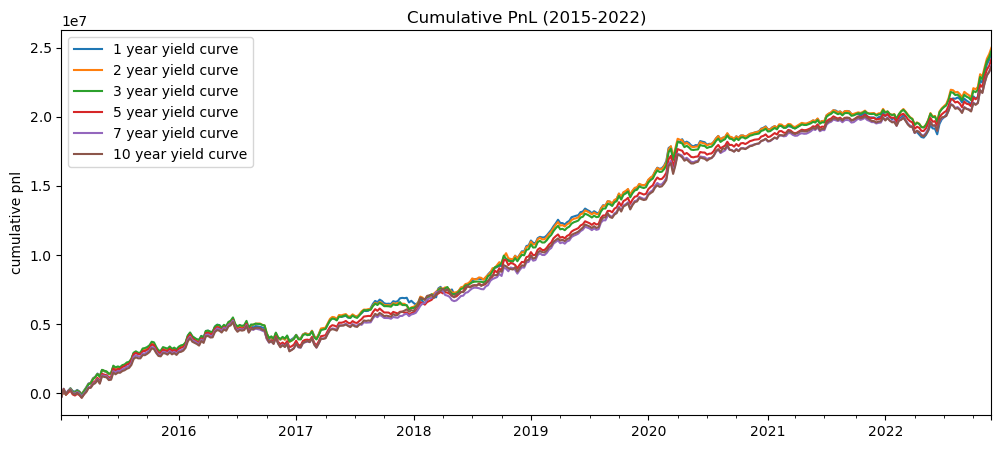

In [108]:
df_compare = result_1Y[['cumulative_pnl']]
df_compare = df_compare.rename(columns={'cumulative_pnl': '1 year yield curve'})
df_compare['2 year yield curve'] = result_2Y['cumulative_pnl']
df_compare['3 year yield curve'] = result_3Y['cumulative_pnl']
df_compare['5 year yield curve'] = result_5Y['cumulative_pnl']
df_compare['7 year yield curve'] = result_7Y['cumulative_pnl']
df_compare['10 year yield curve'] = result_10Y['cumulative_pnl']

df_compare.plot(title="Cumulative PnL (2015-2022)", ylabel = "cumulative pnl" ,figsize = (12,5));

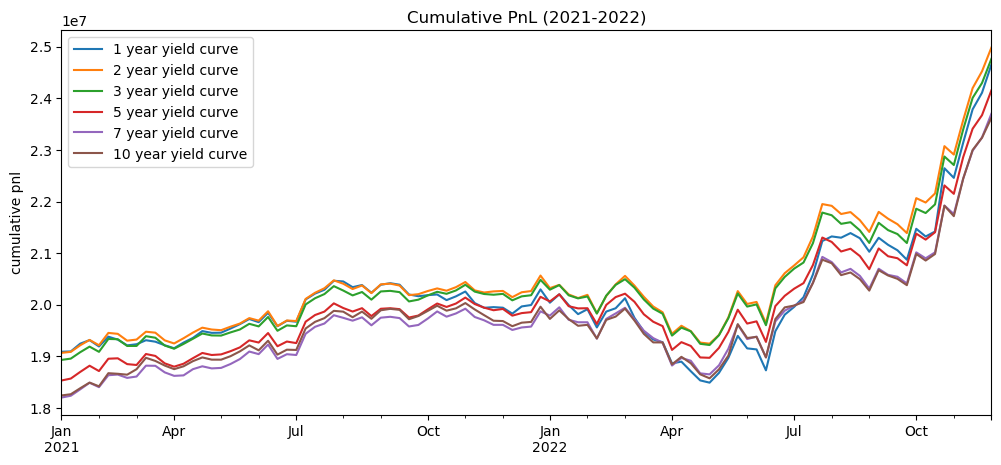

In [97]:
df_compare["2021":].plot(title="Cumulative PnL (2021-2022)", ylabel = "cumulative pnl" ,figsize = (12,5));

Based on the metrics data and plots of cumulative PnL, we could conclude that there is no large differences between results of using different years of yield curves. Using 2 year yield curve achieved the highest Sharpe ratio of 0.2797 and the smallest maximum drawdown of -0.169542. After zooming in on the cumulative PnL between 2021 to 2022, we can see that the 2 year yield curve dataset achieved the highest cumulative PnL in the end as well. At the same time, the 7 year and 10 year yield curve performed the worst.

Historical yield curves may contain more economic information, meanwhile, up-to-date market expectations for interest rates are likely to provide better results. This probabily could explain why using 2 year yield curve can achieve the best performance in carry trade.

#### Choose the foreign currency with the lowest yield curve rate

In the FX carry strategy I have implemented, every week I choose the foreign currency with the highest yield curve as the currency to lend, which is approximately Vietnamese Dong before 2018, and Philippine Peso afterwards. In the following discussion, we choose currency to lend with the lowest yield curve rate to see if the diffience of choice could influence the performance.

In [101]:
def carry_strategy2(df):

    return df_result

In [111]:
result_1Y_2 = carry_strategy2(df_1Y)
result_2Y_2 = carry_strategy2(df_2Y)
result_3Y_2 = carry_strategy2(df_3Y)
result_5Y_2 = carry_strategy2(df_5Y)
result_7Y_2 = carry_strategy2(df_7Y)
result_10Y_2 = carry_strategy2(df_10Y)

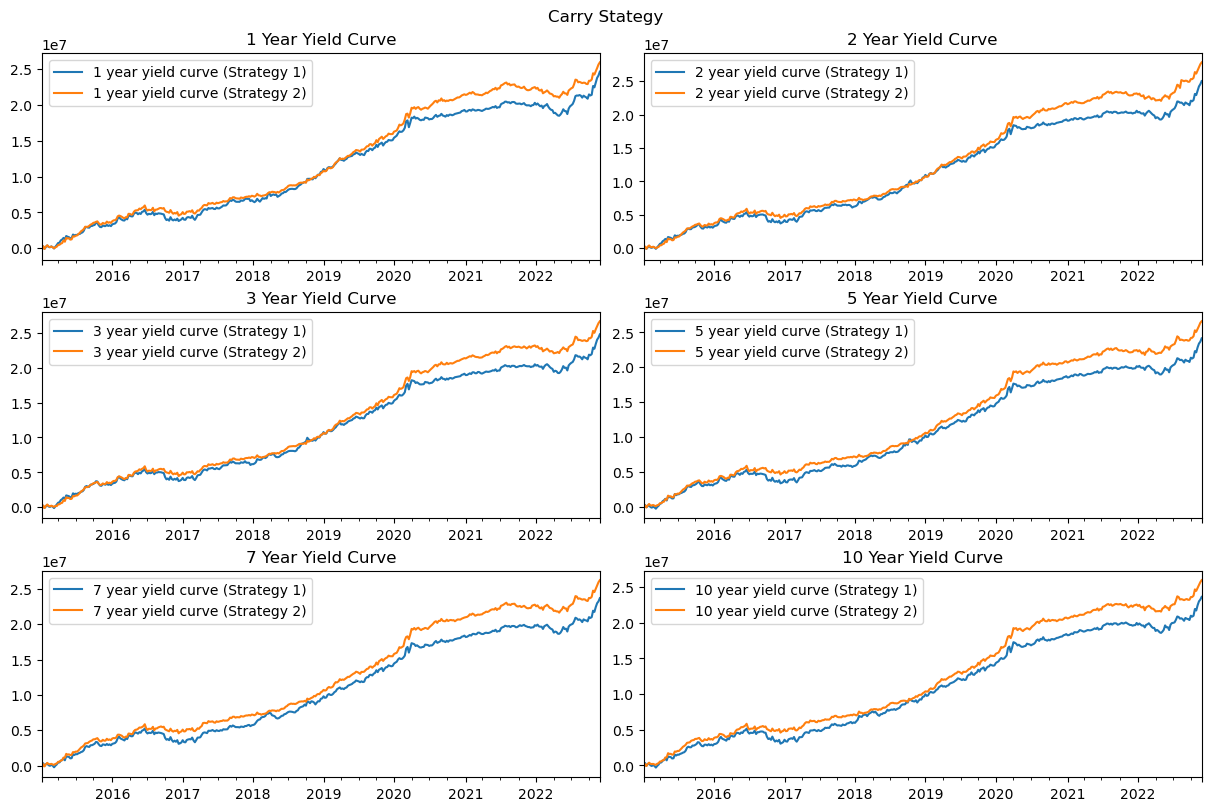

In [120]:
fig, axes = plt.subplots(nrows=3, ncols=2,constrained_layout=True)

df_compare1 = result_1Y[['cumulative_pnl']]
df_compare1 = df_compare1.rename(columns={'cumulative_pnl': '1 year yield curve (Strategy 1)'})
df_compare1['1 year yield curve (Strategy 2)'] = result_1Y_2['cumulative_pnl']

df_compare2 = result_2Y[['cumulative_pnl']]
df_compare2 = df_compare2.rename(columns={'cumulative_pnl': '2 year yield curve (Strategy 1)'})
df_compare2['2 year yield curve (Strategy 2)'] = result_2Y_2['cumulative_pnl']

df_compare3 = result_3Y[['cumulative_pnl']]
df_compare3 = df_compare3.rename(columns={'cumulative_pnl': '3 year yield curve (Strategy 1)'})
df_compare3['3 year yield curve (Strategy 2)'] = result_3Y_2['cumulative_pnl']

df_compare5 = result_5Y[['cumulative_pnl']]
df_compare5 = df_compare5.rename(columns={'cumulative_pnl': '5 year yield curve (Strategy 1)'})
df_compare5['5 year yield curve (Strategy 2)'] = result_5Y_2['cumulative_pnl']

df_compare7 = result_7Y[['cumulative_pnl']]
df_compare7 = df_compare7.rename(columns={'cumulative_pnl': '7 year yield curve (Strategy 1)'})
df_compare7['7 year yield curve (Strategy 2)'] = result_7Y_2['cumulative_pnl']

df_compare10 = result_10Y[['cumulative_pnl']]
df_compare10 = df_compare10.rename(columns={'cumulative_pnl': '10 year yield curve (Strategy 1)'})
df_compare10['10 year yield curve (Strategy 2)'] = result_10Y_2['cumulative_pnl']

df_compare1.plot(ax=axes[0,0],title= "1 Year Yield Curve",figsize = (12,8))
df_compare2.plot(ax=axes[0,1],title= "2 Year Yield Curve",figsize = (12,8))
df_compare3.plot(ax=axes[1,0],title= "3 Year Yield Curve",figsize = (12,8))
df_compare5.plot(ax=axes[1,1],title= "5 Year Yield Curve",figsize = (12,8))
df_compare7.plot(ax=axes[2,0],title= "7 Year Yield Curve",figsize = (12,8))
df_compare10.plot(ax=axes[2,1],title= "10 Year Yield Curve",figsize = (12,8))

fig.suptitle("Carry Stategy");

Investors who engage in carry trades typically look for yield curves that are steeply sloped, as this indicates a large differential between short-term and long-term interest rates. In a steep yield curve environment, the investor can earn a higher return by borrowing at short-term rates and investing in longer-term bonds that offer higher yields. 

However, according to the above results, choosing currency to lend with the lowest yield curve rate could achieve a better performance in using all years of yield curves. Thai Baht with the lowest yield curve rate has the least steep yield curve. The reason why Strategy 2 outpermed Strategy 1 could be that even though the other two foreign currencies have more steep yield curves, Thai Baht, however, has a more different and unrelated interest rate comparing with British Pound, therefore, the carry strategy could better capture the difference in interest rates.

#### Choose the same foreign currency without changing every week

In Strategy 1 and 2, we change the foreign currency to lend every week based on yield curve rate. The following discussion would compare the difference of performance if we use the same foreign currency all the time without changing every week.

In [137]:
def carry_strategy3(df):

    return df_result

In [138]:
result_1Y_3 = carry_strategy3(df_1Y)
result_2Y_3 = carry_strategy3(df_2Y)
result_3Y_3 = carry_strategy3(df_3Y)
result_5Y_3 = carry_strategy3(df_5Y)
result_7Y_3 = carry_strategy3(df_7Y)
result_10Y_3 = carry_strategy3(df_10Y)

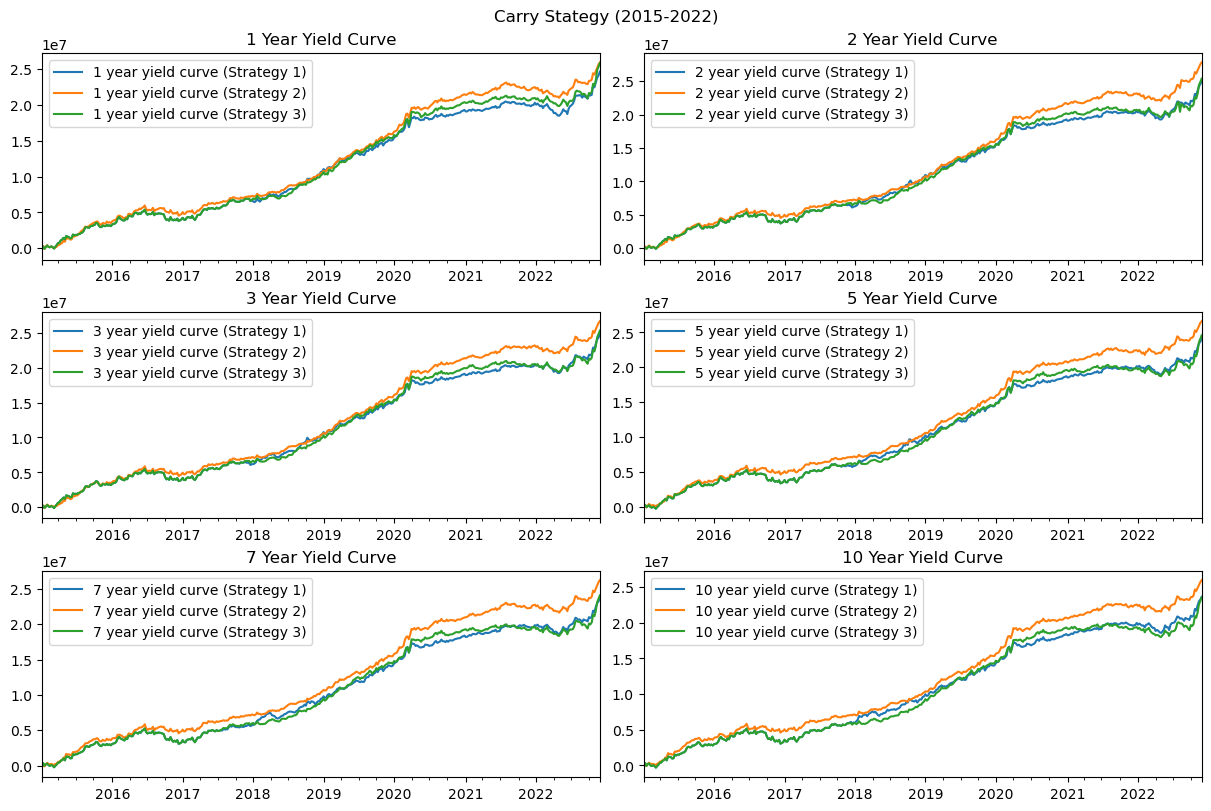

In [139]:
fig, axes = plt.subplots(nrows=3, ncols=2,constrained_layout=True)

df_compare1['1 year yield curve (Strategy 3)'] = result_1Y_3['cumulative_pnl']
df_compare2['2 year yield curve (Strategy 3)'] = result_2Y_3['cumulative_pnl']
df_compare3['3 year yield curve (Strategy 3)'] = result_3Y_3['cumulative_pnl']
df_compare5['5 year yield curve (Strategy 3)'] = result_5Y_3['cumulative_pnl']
df_compare7['7 year yield curve (Strategy 3)'] = result_7Y_3['cumulative_pnl']
df_compare10['10 year yield curve (Strategy 3)'] = result_10Y_3['cumulative_pnl']

df_compare1.plot(ax=axes[0,0],title= "1 Year Yield Curve",figsize = (12,8))
df_compare2.plot(ax=axes[0,1],title= "2 Year Yield Curve",figsize = (12,8))
df_compare3.plot(ax=axes[1,0],title= "3 Year Yield Curve",figsize = (12,8))
df_compare5.plot(ax=axes[1,1],title= "5 Year Yield Curve",figsize = (12,8))
df_compare7.plot(ax=axes[2,0],title= "7 Year Yield Curve",figsize = (12,8))
df_compare10.plot(ax=axes[2,1],title= "10 Year Yield Curve",figsize = (12,8))

fig.suptitle("Carry Stategy (2015-2022)");

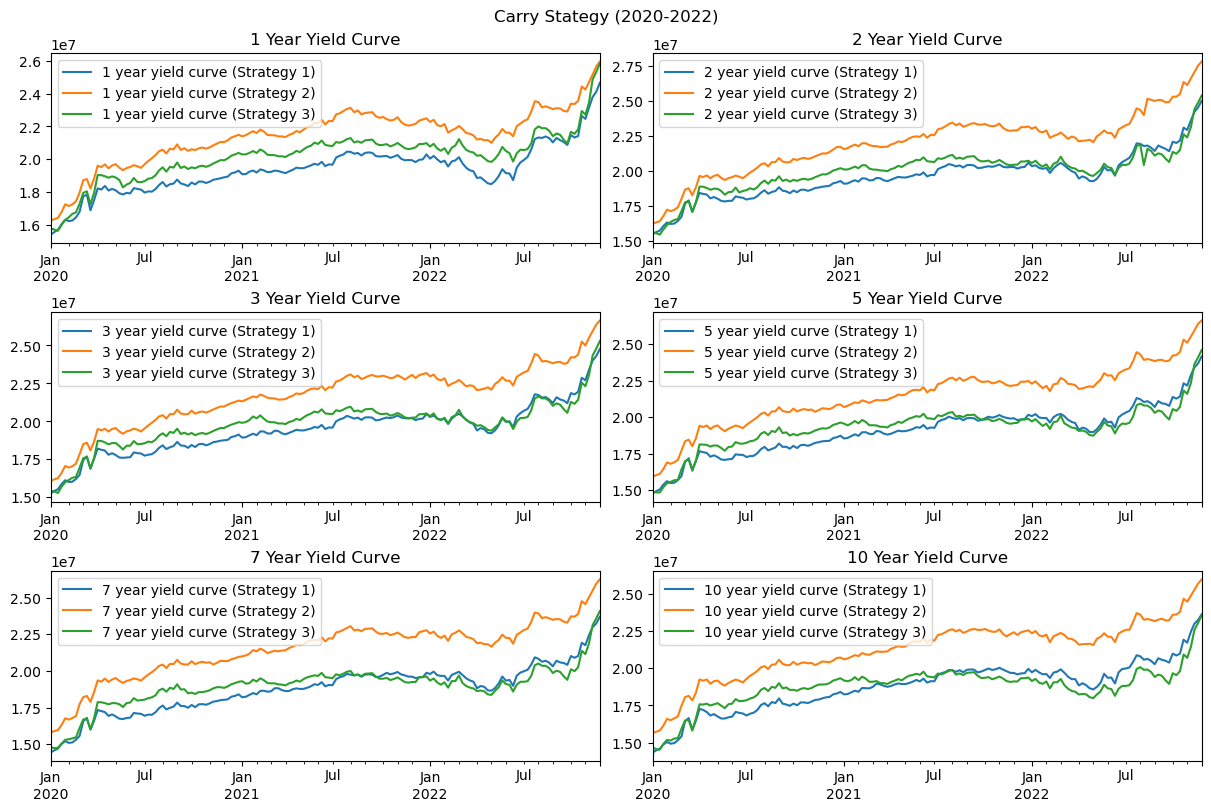

In [140]:
fig, axes = plt.subplots(nrows=3, ncols=2,constrained_layout=True)

df_compare1['1 year yield curve (Strategy 3)'] = result_1Y_3['cumulative_pnl']
df_compare2['2 year yield curve (Strategy 3)'] = result_2Y_3['cumulative_pnl']
df_compare3['3 year yield curve (Strategy 3)'] = result_3Y_3['cumulative_pnl']
df_compare5['5 year yield curve (Strategy 3)'] = result_5Y_3['cumulative_pnl']
df_compare7['7 year yield curve (Strategy 3)'] = result_7Y_3['cumulative_pnl']
df_compare10['10 year yield curve (Strategy 3)'] = result_10Y_3['cumulative_pnl']

df_compare1['2020':].plot(ax=axes[0,0],title= "1 Year Yield Curve",figsize = (12,8))
df_compare2['2020':].plot(ax=axes[0,1],title= "2 Year Yield Curve",figsize = (12,8))
df_compare3['2020':].plot(ax=axes[1,0],title= "3 Year Yield Curve",figsize = (12,8))
df_compare5['2020':].plot(ax=axes[1,1],title= "5 Year Yield Curve",figsize = (12,8))
df_compare7['2020':].plot(ax=axes[2,0],title= "7 Year Yield Curve",figsize = (12,8))
df_compare10['2020':].plot(ax=axes[2,1],title= "10 Year Yield Curve",figsize = (12,8))

fig.suptitle("Carry Stategy (2020-2022)");

In Strategy 3, we choose Vietnamese Dong as the foreign currency to lend all the time. According to the above the results, Strategy 2 outperforms other strategies in all years of yield curves. Remaining the same foreign currency achieves a better cumulative PnL than changing currency every week when using yield curve rates of one year. However, as the year of yield curve increases, Strategy 1 performs better and better than Strategy 3. As a result, we should still choose to change the currency every week if the year of yield curve is large.

## Possible improvements to the strategy

FX carry strategy did not achieve a good performance, since the Sharpe ratio is only around 0.27. The strategy could fail for several reasons. 

For example, the strategy could fail due to exchange rate fluctuations. If the currency we borrow appreciates relative to the currency we invest in, the returns will decrease. 

Changes in interest rates can also impact a carry trade strategy. If the central bank of the country whose currency we are borrowing in increases interest rates, the value of that currency could increase, making it more expensive to repay the debt. 

Policy changes and political instability in the country whose currency we are investing in could also lead to the failure of the strategy. 

There are several possible improvements to the FX carry strategy.

* **Diversify the portfolio of currencies and investments.** It can help reduce the overall risk of the FX carry strategy. By investing in a range of currencies and avoiding concentration in a single currency, investors can reduce the impact of any negative events that may occur in a particular market.

* **Choose the right time.** Timing is important in carry trade, as market conditions can change rapidly. It is important to monitor the spread between interest rates and to enter and exit positions at the right time to maximize returns.

* **Try to manage the risk.** Effective risk management is essential for successful carry trade, as the strategy involves borrowing in one currency and investing in another. It is important to manage the risk of adverse events such as interest rate hikes, currency devaluations, and economic downturns, which can impact the profitability of a carry trade strategy.

## Conclusion

In this study, I implemented a FX carry stategy by borrowing in a low interest rate currency and lending another currency with high interest rate, which is achieved through a cross-currency swap. Discussions,analysis and results are as follows.

* There is no large differences between results of using different years of yield curves. Using 2 year yield curve achieved the highest Sharpe ratio of 0.2797 and the smallest maximum drawdown of -0.169542. Historical yield curves may contain more economic information, meanwhile, up-to-date market expectations for interest rates are likely to provide better results. This probabily could explain why using 2 year yield curve can achieve the best performance in carry trade.

* Choosing currency to lend with the lowest yield curve rate could achieve a better performance in using all years of yield curves, however, Thai Baht with the lowest yield curve rate has the least steep yield curve. The reason could be that even though the other two foreign currencies have more steep yield curves, Thai Baht has a more different and unrelated interest rate comparing with British Pound, therefore, the carry strategy could better capture the difference in interest rates.

* We should choose to change the currency every week for diversification instead of choosing the same foreign currency all the time.